# Bone Metastasis Classification using MobileNet v2

This notebook performs bone metastasis classification using pre-trained MobileNet v2, with all existing layers frozen and all fine-tuned layers unfrozen.

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchstat import stat
from torchsummary import summary

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Define Variables & Helper Functions

In [2]:
# Set seed for random number generation to create reproducible results
random_seed = 5
torch.manual_seed(random_seed)

In [3]:
# Data augmentation and normalization according to the MobileNet configuration
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Helper function to get ground truth class of an image
def get_img_labels(img_dir):
    labels = ''
    
    for filename in os.listdir(img_dir):
        # If image has no metastasis
        if (filename[5] == '0'):
            labels += filename + ",0\n"
            
        # If image has metastasis
        else:
            labels += filename + ",1\n"
        
    return labels

### Load Data

In [5]:
data_dir = 'dataset-sample-flat'

In [6]:
# Image dataset
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(StringIO(get_img_labels(img_dir)), sep=",", header=None)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Read and transform image
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        
        # Determine ground truth class (metastasis or no metastasis)
        label = self.img_labels.iloc[idx, 1]
        return image, label

In [7]:
# Dataset and dataloader for training data
dataset = CustomDataset(img_dir=data_dir, transform=preprocess)
labels = list(dataset.img_labels.iloc[:, 1])

### Define Model

In [8]:
# Model hyperparameters; epochs & batch size from Magboo & Abu
k_folds = 3 # TODO: Change to 10
epochs = 2 # TODO: Change to 100
batch_size = 16

In [9]:
# Allocate tensors to the device used for computation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Performing torch operations on {device} device")

Performing torch operations on cpu device


### Train Model

In [10]:
# Evaluation metrics
results_accuracy = []
results_precision = []
results_sensitivity = []
results_specificity = []
results_f1 = []
train_losses = []
test_losses = []

In [11]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

In [13]:
# Train model for k folds, with e epochs each
for fold, (train_indices, test_indices) in enumerate(kfold.split(dataset)):
    print('-' * 50)
    print(f'FOLD {fold+1}/{k_folds}:')
    print('-' * 50)
    
    # Sample elements randomly from selected train/test indices
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)
    
    # Get DataLoaders for training and test sets
    trainloader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=batch_size, 
                                              sampler=train_subsampler)
    
    testloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size, 
                                             sampler=test_subsampler)
    
    train_losses.append([])
    test_losses.append([])
    
    # Load pre-trained MobileNet v2 model
    model = models.mobilenet_v2(weights="MobileNet_V2_Weights.IMAGENET1K_V1").to(device)
    
    # Fine-tune model: Change last layer to output two classes
    model.classifier[1] = nn.Linear(in_features = model.classifier[1].in_features, out_features = 2)
    model.classifier.append(nn.Softmax(dim = 1))
    
    # Freeze all layers except the fine-tuned layer
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    # Define criterion (function used to compute loss) and optimizer for model
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # ---------- Run for x epochs on training set and test set ----------
    for epoch in range(epochs):
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
                dataloader = trainloader
            else:
                model.eval()
                dataloader = testloader

            running_loss = 0.0
            running_corrects = 0
            total_batch_count = 0

            for inputs, labels in dataloader:
                # Get the inputs
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    # Backpropagation
                    optimizer.zero_grad() # Reset gradients from previous passes
                    loss.backward() # Compute gradients using derivative of loss
                    optimizer.step() # Update values using gradients
                
                total_batch_count += 1 # Increment number of finished batches
                running_loss += loss.item() # Add batch loss to current epoch loss

            running_loss /= total_batch_count
            
            if phase == 'train':
                train_losses[fold].append(running_loss)
                print(f"Epoch {epoch+1}/{epochs} Training Loss: {running_loss}")
            else:
                test_losses[fold].append(running_loss)
                print(f"Epoch {epoch+1}/{epochs} Test Loss: {running_loss}")
                  
    # ---------- Get performance metrics for this fold ----------
    print('-' * 50)
    print(f'FOLD {fold+1}/{k_folds}: Test Results')
    print('-' * 50)

    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for batch_index, batch_data in enumerate(testloader):
            # Get the inputs; data is a list of [images, labels]
            images, labels = batch_data

            # Forward pass
            predictions = model(images)

            # Set total and correct
            _, predicted = torch.max(input=predictions, dim=1) # Get list of predicted classes
            
            # Get how many classes there were in this batch
            total += labels.size(0)
            
            # Get true positive, true negative, false positive, and false negative counts
            for index in range(len(labels)):
                true_pos = true_pos+1 if (predicted[index] == 1 and labels[index] == 1) else true_pos
                true_neg = true_neg+1 if (predicted[index] == 0 and labels[index] == 0) else true_neg
                false_pos = false_pos+1 if (predicted[index] == 1 and labels[index] == 0) else false_pos
                false_neg = false_neg+1 if (predicted[index] == 0 and labels[index] == 1) else false_neg
    
    print(f"TP: {true_pos}, TN: {true_neg}, FP: {false_pos}, FN: {false_neg}, total: {total}")
    
    # Get evaluation metrics
    # accuracy: (tp + tn) / (p + n)
    accuracy = (true_pos + true_neg)/total if total != 0 else 0
    print(f"Accuracy: {accuracy}")
    results_accuracy.append(accuracy)
    
    # precision tp / (tp + fp)
    precision = true_pos/(true_pos + false_pos) if (true_pos + false_pos) != 0 else 0
    print(f"Precision: {precision}")
    results_precision.append(precision)
    
    # sensitivity: tp / (tp + fn)
    sensitivity = true_pos/(true_pos + false_neg) if (true_pos + false_neg) != 0 else 0
    print(f"Sensitivity: {sensitivity}")
    results_sensitivity.append(sensitivity)
    
    # specificity: tn / (tn + fp)
    specificity = true_neg/(true_neg + false_pos) if (true_neg + false_pos) != 0 else 0
    print(f"Specificity: {specificity}")
    results_specificity.append(specificity)
    
    # f1: 2(precision * recall)/(precision + recall)
    f1 = 2 * (precision * sensitivity)/(precision + sensitivity) if (precision + sensitivity) != 0 else 0
    print(f"F1: {f1}")
    results_f1.append(f1)

--------------------------------------------------
FOLD 1/3:
--------------------------------------------------
Epoch 1/2 Training Loss: 0.6553468373086717
Epoch 1/2 Test Loss: 0.6067033052444458
Epoch 2/2 Training Loss: 0.6455635560883416
Epoch 2/2 Test Loss: 0.6046202719211579
--------------------------------------------------
FOLD 1/3: Test Results
--------------------------------------------------
TP: 0, TN: 45, FP: 0, FN: 22, total: 67
Accuracy: 0.6716417910447762
Precision: 0
Sensitivity: 0.0
Specificity: 1.0
F1: 0
--------------------------------------------------
FOLD 2/3:
--------------------------------------------------
Epoch 1/2 Training Loss: 0.7065130405955844
Epoch 1/2 Test Loss: 0.6733255505561828
Epoch 2/2 Training Loss: 0.6679491466946073
Epoch 2/2 Test Loss: 0.6465295314788818
--------------------------------------------------
FOLD 2/3: Test Results
--------------------------------------------------
TP: 0, TN: 43, FP: 0, FN: 24, total: 67
Accuracy: 0.6417910447761194

### Save Model

In [14]:
# Print tensor sizes per layer in model
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
features.0.0.weight 	 torch.Size([32, 3, 3, 3])
features.0.1.weight 	 torch.Size([32])
features.0.1.bias 	 torch.Size([32])
features.0.1.running_mean 	 torch.Size([32])
features.0.1.running_var 	 torch.Size([32])
features.0.1.num_batches_tracked 	 torch.Size([])
features.1.conv.0.0.weight 	 torch.Size([32, 1, 3, 3])
features.1.conv.0.1.weight 	 torch.Size([32])
features.1.conv.0.1.bias 	 torch.Size([32])
features.1.conv.0.1.running_mean 	 torch.Size([32])
features.1.conv.0.1.running_var 	 torch.Size([32])
features.1.conv.0.1.num_batches_tracked 	 torch.Size([])
features.1.conv.1.weight 	 torch.Size([16, 32, 1, 1])
features.1.conv.2.weight 	 torch.Size([16])
features.1.conv.2.bias 	 torch.Size([16])
features.1.conv.2.running_mean 	 torch.Size([16])
features.1.conv.2.running_var 	 torch.Size([16])
features.1.conv.2.num_batches_tracked 	 torch.Size([])
features.2.conv.0.0.weight 	 torch.Size([96, 16, 1, 1])
features.2.conv.0.1.weight 	 torch.Size([96])
features.2.conv.

features.15.conv.0.1.running_mean 	 torch.Size([960])
features.15.conv.0.1.running_var 	 torch.Size([960])
features.15.conv.0.1.num_batches_tracked 	 torch.Size([])
features.15.conv.1.0.weight 	 torch.Size([960, 1, 3, 3])
features.15.conv.1.1.weight 	 torch.Size([960])
features.15.conv.1.1.bias 	 torch.Size([960])
features.15.conv.1.1.running_mean 	 torch.Size([960])
features.15.conv.1.1.running_var 	 torch.Size([960])
features.15.conv.1.1.num_batches_tracked 	 torch.Size([])
features.15.conv.2.weight 	 torch.Size([160, 960, 1, 1])
features.15.conv.3.weight 	 torch.Size([160])
features.15.conv.3.bias 	 torch.Size([160])
features.15.conv.3.running_mean 	 torch.Size([160])
features.15.conv.3.running_var 	 torch.Size([160])
features.15.conv.3.num_batches_tracked 	 torch.Size([])
features.16.conv.0.0.weight 	 torch.Size([960, 160, 1, 1])
features.16.conv.0.1.weight 	 torch.Size([960])
features.16.conv.0.1.bias 	 torch.Size([960])
features.16.conv.0.1.running_mean 	 torch.Size([960])
featur

In [15]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {156: {'step': tensor(18.), 'exp_avg': tensor([[ 0.0009, -0.0175, -0.0245,  ..., -0.0110, -0.0210, -0.0186],
        [-0.0009,  0.0175,  0.0245,  ...,  0.0110,  0.0210,  0.0186]]), 'exp_avg_sq': tensor([[3.8011e-05, 2.9426e-05, 5.1475e-05,  ..., 1.8886e-05, 3.1526e-05,
         3.8966e-05],
        [3.8011e-05, 2.9426e-05, 5.1475e-05,  ..., 1.8886e-05, 3.1526e-05,
         3.8966e-05]])}, 157: {'step': tensor(18.), 'exp_avg': tensor([-0.0384,  0.0384]), 'exp_avg_sq': tensor([9.4197e-05, 9.4197e-05])}}
param_groups 	 [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 6

In [25]:
# Save weights from fine-tuning pre-trained model
torch.save(model.state_dict(), 'weights/mobilenet_weights.h5')

### Evaluate Model

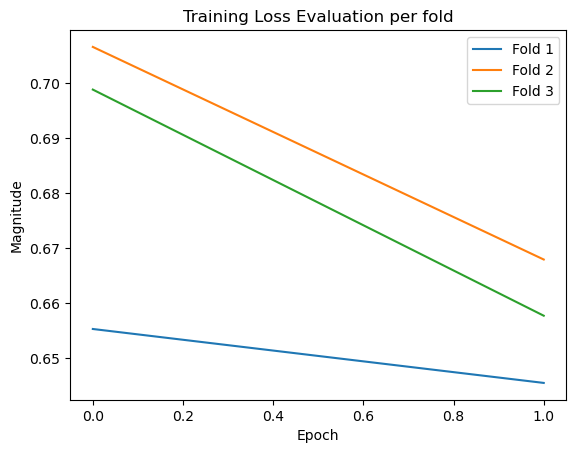

In [26]:
# Plot train losses
ax = plt.axes()
for fold_losses in train_losses:
    plt.plot(fold_losses)
plt.title('Training Loss Evaluation per fold')
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.legend(['Fold ' + str(x) for x in range(1, k_folds+1)])
plt.show()

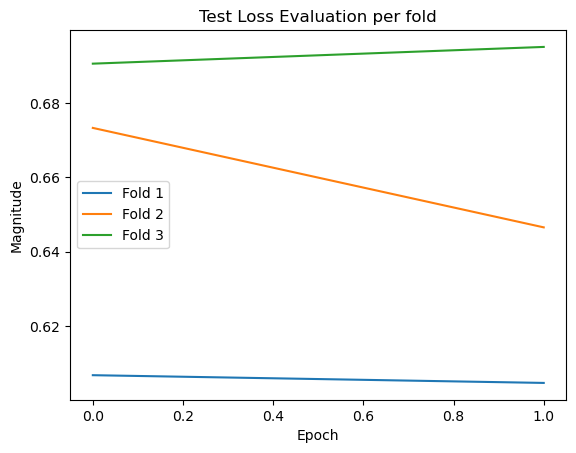

In [27]:
# Plot test losses
ax = plt.axes()
for fold_losses in test_losses:
    plt.plot(fold_losses)
plt.title('Test Loss Evaluation per fold')
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.legend(['Fold ' + str(x) for x in range(1, k_folds+1)])
plt.show()

In [28]:
# Get performance metrics by calculcating average of metrics across all folds
print("Final Performance Metrics")
print(f"Accuracy: {np.mean(results_accuracy)}")
print(f"Precision: {np.mean(results_precision)}")
print(f"Sensitivity: {np.mean(results_sensitivity)}")
print(f"Specificity: {np.mean(results_specificity)}")
print(f"F1: {np.mean(results_f1)}")

Final Performance Metrics
Accuracy: 0.6549826624453491
Precision: 0.0
Sensitivity: 0.0
Specificity: 1.0
F1: 0.0


In [29]:
# Get computational complexity
stat(model, (3, 646, 220))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[Flops]: Softmax is not supported!
[Memory]: Softmax is not supported!
[Flops]: Softmax is not supported!
[Memory]: Softmax is not supported!
                module name   input shape  output shape     params memory(MB)             MAdd          Flops  MemRead(B)  MemWrite(B) duration[%]    MemR+W(B)
0              features.0.0     3 646 220    32 323 110      864.0       4.34     60,258,880.0   30,697,920.0   1705440.0    4547840.0       2.37%    6253280.0
1              features.0.1    32 323 110    32 323 110       64.0       4.34      4,547,840.0    2,273,920.0   4548096.0    4547840.0       0.68%    9095936.0
2              features.0.2    32 323 110    32 323 110        0.0       4.34      1,136,960.0    1,136,960.0   4547840.0    4547840.0       0.68%    9095680.0
3       

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


### Show Predictions on Sample Images

In [30]:
sample_img_names = ["0000-0-A.tif", "0163-0-P.tif", "0198-0-A.tif"]
sample_img_paths = [(data_dir + "/" + sample_img_names[i]) for i in range(len(sample_img_names))]
sample_classes = [sample_img_names[i][5] for i in range(len(sample_img_names))]
sample_ground_truths = ["No Metastasis" if sample_classes[i] == 0 else "Metastasis" for i in range(len(sample_img_names))]
sample_imgs = [Image.open(img_path).convert('RGB') for img_path in sample_img_paths]
sample_imgs_show = [Image.open(img_path) for img_path in sample_img_paths]

In [31]:
validation_batch = torch.stack([preprocess(img).to(device) for img in sample_imgs])

In [32]:
sample_preds= model(validation_batch).detach().cpu().data.numpy()
sample_preds

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[Flops]: Softmax is not supported!
[Memory]: Softmax is not supported!
[Flops]: Softmax is not supported!
[Memory]: Softmax is not supported!


array([[0.7027733 , 0.2972268 ],
       [0.82930094, 0.17069909],
       [0.7439355 , 0.25606444]], dtype=float32)

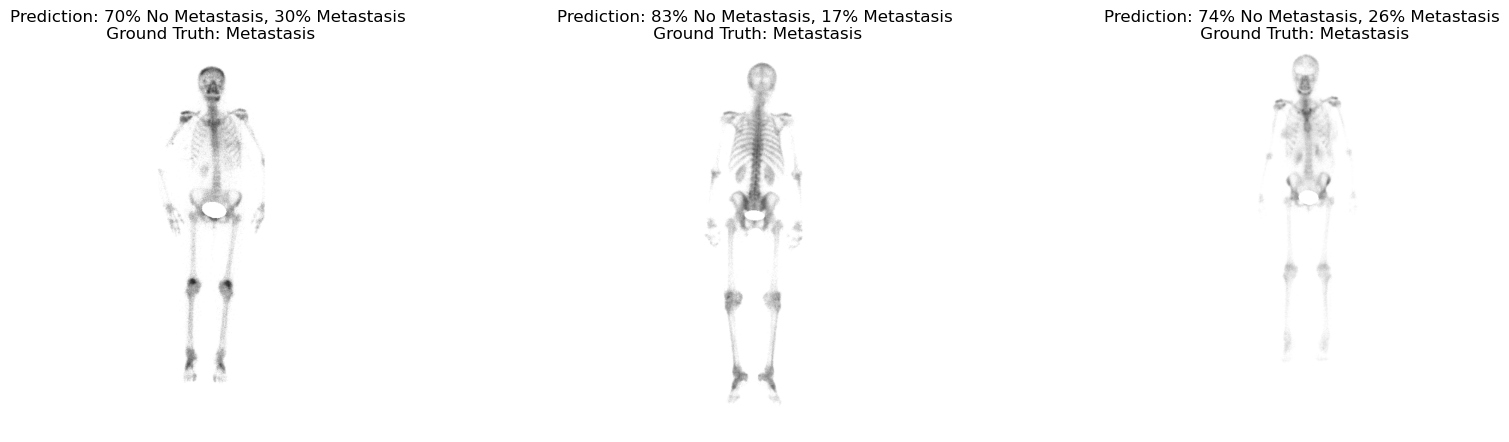

In [33]:
fig, axs = plt.subplots(1, len(sample_imgs_show), figsize=(20, 5))
for i, img in enumerate(sample_imgs_show):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("Prediction: {:.0f}% No Metastasis, {:.0f}% Metastasis\n Ground Truth: {}"
                 .format(100*sample_preds[i,0], 100*sample_preds[i,1], sample_ground_truths[i]))
    ax.imshow(img)